In [25]:
import pickle
import datetime
import time

import pandas as pd
import numpy as np

import scipy

import tweepy

from nltk.tokenize.casual import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
tknzr = TweetTokenizer()
def tweet_tokenize(msg):
    return tknzr.tokenize(msg)

def remove_retweet(msg):
    return ' '.join(filter(lambda x:x[0]!='@' and not x.startswith('http'), msg.split()))

def convert_date(timestamp):
    if type(timestamp) is datetime.datetime:
        date = timestamp    
    else:
        date = datetime.datetime.fromtimestamp(timestamp)

    h = date.hour
    
    if h >= 23 or h <= 5:
        d_type = 0 #Night
    elif h > 5 and h <= 11:
        d_type = 1 #Morning
    elif h > 11 and h <= 18:
        d_type = 2 #Midday
    else:
        d_type = 3 #Evening
    
    return pd.Series({'Weekday':date.weekday(), 'DayPart': d_type})

def convert_date(timestamp):
    if type(timestamp) is datetime.datetime:
        date = timestamp
    elif type(timestamp) is str:
        #2016-07-23 15:10:14
        date = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S")
    else:
        date = datetime.datetime.fromtimestamp(timestamp)

    h = date.hour
    
    if h >= 23 or h <= 5:
        d_type = 0 #Night
    elif h > 5 and h <= 11:
        d_type = 1 #Morning
    elif h > 11 and h <= 18:
        d_type = 2 #Midday
    else:
        d_type = 3 #Evening
    
    return pd.Series({'Weekday':date.weekday(), 'DayPart': d_type})

def preprocess_tweet(text, date):
        text = vectorizer.transform([remove_retweet(text)])
        date = enc.transform([convert_date(date)])

        return scipy.sparse.hstack([text, date])
    
def rename_type(num):
    if num == -1:
        return 'neg'
    else:
        return 'pos'

In [4]:
with open('models/model_sgd.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/vectrorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('models/one_hot.pkl', 'rb') as f:
    enc = pickle.load(f)

In [5]:
X = pd.read_csv('data/old_tweets/MIPT.csv', sep = ';', names = ['Date', 'Text'])

In [21]:
date_col = enc.transform(X['Date'].apply(convert_date))
tweets = vectorizer.transform(X['Text'])
X_tweets = scipy.sparse.hstack([tweets, date_col])

In [28]:
X['Type'] = model.predict(X_tweets)
X['Type'] = X['Type'].apply(rename_type)

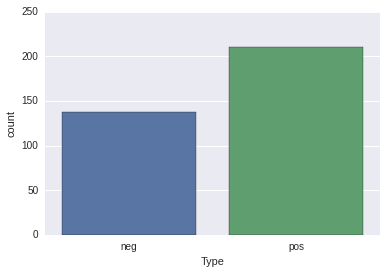

In [29]:
sns.countplot(x='Type', data=X)